missing_pattern_plot(matrix, x, sorty)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patterns.missing_pattern_plot as missing_pattern_plot

ModuleNotFoundError: No module named 'pandas'

# Dummy Data

In [69]:
# create a multi-index dataframe header
header = pd.MultiIndex.from_product([['heart_rate', 'steps'],
                                     ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00',
                                      '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
                                      '21:00', '22:00', '23:00']],
                                      names=['type', 'time'])

# Generate dummy data
num_rows = 100
num_columns = 48
data = np.random.choice([True, False], size=(num_rows, num_columns))

# Create DataFrame
person_ids = range(1, num_rows + 1)
df = pd.DataFrame(data, index=person_ids, columns=header)

df.head()

type heart_rate                                                          \
time       0:00   1:00   2:00   3:00   4:00   5:00   6:00   7:00   8:00   
1         False   True   True  False   True  False   True  False  False   
2         False   True  False   True  False   True  False  False  False   
3         False  False   True  False  False   True   True   True   True   
4          True   True   True  False  False  False   True  False   True   
5         False   True   True   True   True   True  False  False  False   

type         ...  steps                                                   \
time   9:00  ...  14:00  15:00  16:00  17:00  18:00  19:00  20:00  21:00   
1      True  ...   True  False   True  False  False  False   True   True   
2     False  ...   True   True  False  False  False   True  False   True   
3     False  ...   True  False   True   True  False   True   True  False   
4      True  ...  False   True   True   True   True   True   True  False   
5      True  ...   True   True   True   True   True   True  False  False   

type                
time  22:00  23:00  
1     False   True  
2     False   True  
3      True   True  
4      True  False  
5     False  False  

[5 rows x 48 columns]

In [94]:
# slicing the dataframe

# get all the heart rates
heart_rates = df.xs('heart_rate', level='type', axis=1)

In [71]:
# get all the 0:00 values
data_slice = df.xs('0:00', level='time', axis=1)

print(isinstance(df, pd.DataFrame))

True


In [101]:
class MissingPatternPlot:
    """draw a heatmap of missingness for a given column"""
    sort = ['person_id', 'missingness']
    direction = ['increasing', 'decreasing']

    def __init__(self, data, column_to_query, study_period):
        # check if data is a dataframe
        if isinstance(data, pd.DataFrame):
            self.data = data
        else:
            plot_data = np.asarray(data)
            self.data = pd.DataFrame(plot_data)

        # check if column_to_query is valid
        if isinstance(column_to_query, str):
            self.column_to_query = column_to_query
        elif column_to_query is None:
            self.column_to_query = None
        else:
            raise ValueError("column_to_query must be a string or None")
        
        # study period
        self.study_period = study_period

    @classmethod
    def initialize(cls, data, column_to_query, study_period):
      """function to initialize the class and parse the data"""
      plot_data = cls(data, column_to_query, study_period)
      plot_data.parse_data(data, column_to_query) # add study period later

      return plot_data

    def parse_data(self, data, column_to_query):
        """function to parse the data and get the column to query if needed"""

        if isinstance(data.columns, pd.MultiIndex) and column_to_query is None:
            raise ValueError("column_to_query needed for multi-index dataframe")

        # check pandas df type and get the column according to the column_to_query
        if isinstance(data.columns, pd.MultiIndex) and column_to_query in data.columns.levels[0]:
            self.data = data.xs(column_to_query, level=0, axis=1)
        elif isinstance(data.columns, pd.MultiIndex) and column_to_query in data.columns.levels[1]:
            self.data = data.xs(column_to_query, level=1, axis=1)
        else:
            if column_to_query is None:
                self.data = data
            elif column_to_query in data.columns:
                self.data = data[column_to_query]
            else:
                raise ValueError("column_to_query must be a valid column name")
            
        self.data.to_csv('curr_data.csv')
    
    def calc_missingness(self, direction):
        """function to calculate the missingness of the given person_id"""
        # make a copy of the dataframe
        plot_data = self.data.copy()

        # count the number of true inputs for each row
        true_count = self.data.astype(bool).sum(axis=1)
        total_inputs = len(self.data.columns)
        true_prop = true_count / total_inputs
        
        # add the true_prop to the dataframe
        self.data['true_prop'] = true_prop

        # sort the dataframe by true_prop
        plot_data = self.data.sort_values(by='true_prop', ascending=direction)

        # drop the true_prop column
        plot_data = plot_data.drop('true_prop', axis=1)

        return plot_data

    def group_by_cluster(self, cluster):
        # make a copy of the dataframe
        plot_data = self.data.copy()

        # add the cluster vector as a new column to the dataframe
        plot_data['cluster'] = cluster

        # sort the df by the 'cluster' column
        df_sorted = plot_data.sort_values(by='cluster')

        # drop cluster column
        df_sorted = df_sorted.drop(columns='cluster')

        return df_sorted

        df_sorted
    
    def plot(self, sort=None, direction=True, x_label=True, y_label=True, x_ticks='auto', y_ticks='auto', title=None):
        """function to plot the missingness heatmap of the given column"""
        """
        Parameters
        ----------
        df : dataframe (T/F inputs)
            dataframe with T/F values with person_id on the y axis and time on the x axis
        column_to_query: str
            name of column in df to check for missingness
        study_period: 
            time period of the study
        sort: str
            column to sort the data by
        direction: bool
            direction to sort the data by
        x_label: bool or str
            label for the x axis
        y_label: bool or str
            label for the y axis
        x_ticks: bool or list
            ticks for the x axis
            if auto: try to densely plot non-overlapping labels
            if true: use the column names, if false: no ticks
            if list: use the list
            if int: take every nth label from the column names
        y_ticks: bool or list
            ticks for the y axis
            if auto: try to densely plot non-overlapping labels
            if true: use the row index, if false: no ticks
            if list: use the list
            if int: take every nth label from the column names
        """

        # PLOT HEURISTICS
        # data for the plot
        plot_data = self.data
        # sort the data by sort and direction
        if sort is None:
            plot_data = self.data
        elif sort in self.sort and isinstance(direction, bool):
            if sort == 'person_id':
                plot_data = self.data.sort_index(axis=0, ascending=direction)
            elif sort == 'missingness':
                plot_data = self.calc_missingness(direction)
            elif sort - 'cluster':
                plot_data = self.data.sort_by_cluster(self.cluster)
        else:
            raise ValueError("sort and direction must be valid inputs")

        # labels on y and x axis
        plot_x_label = None
        plot_y_label = None
        if isinstance(x_label, bool): 
            plot_x_label = self.data.columns.name if x_label else None
        elif isinstance(x_label, str):
            plot_x_label = x_label
        else:
            raise ValueError("x_label must be a bool or string")
        
        if isinstance(y_label, bool):
            plot_y_label = 'person_id' if y_label else None
        elif isinstance(y_label, str):
            plot_y_label = y_label
        else:
            raise ValueError("y_label must be a bool or string")
        
        # ticks on y and x axis
        plot_x_ticks = None
        plot_y_ticks = None
        if isinstance(x_ticks, bool):
            plot_x_ticks = plot_data.columns if x_ticks else None
        elif isinstance(x_ticks, list) or isinstance(x_ticks, int):
            plot_x_ticks = x_ticks
        elif isinstance(x_ticks, str) and x_ticks == 'auto':
            plot_x_ticks = x_ticks
        else:
            raise ValueError("x_ticks must be a bool, list, or integer")

        if isinstance(y_ticks, bool):
            plot_y_ticks = plot_data.index if y_ticks else None
        elif isinstance(y_ticks, list) or isinstance(y_ticks, int):
            plot_y_ticks = y_ticks
        elif isinstance(y_ticks, str) and y_ticks == 'auto':
            plot_y_ticks = y_ticks
        else:
            raise ValueError("y_ticks must be a bool, list, or integer")

        # plot the heatmap
        plt.figure(figsize=(15, 15))
        sns.heatmap(plot_data, cbar=False, xticklabels=plot_x_ticks, yticklabels=plot_y_ticks, cmap='plasma')
        plt.xlabel(plot_x_label)
        plt.ylabel(plot_y_label)
        if isinstance(title, str):
            plt.title(f"Missingness Plot for {title}")
        elif self.column_to_query:
            plt.title(f"Missingness Plot for {self.column_to_query}")
        else:
            plt.title(f"Missingness Plot")
        plt.show()
            

# Testing Visualization

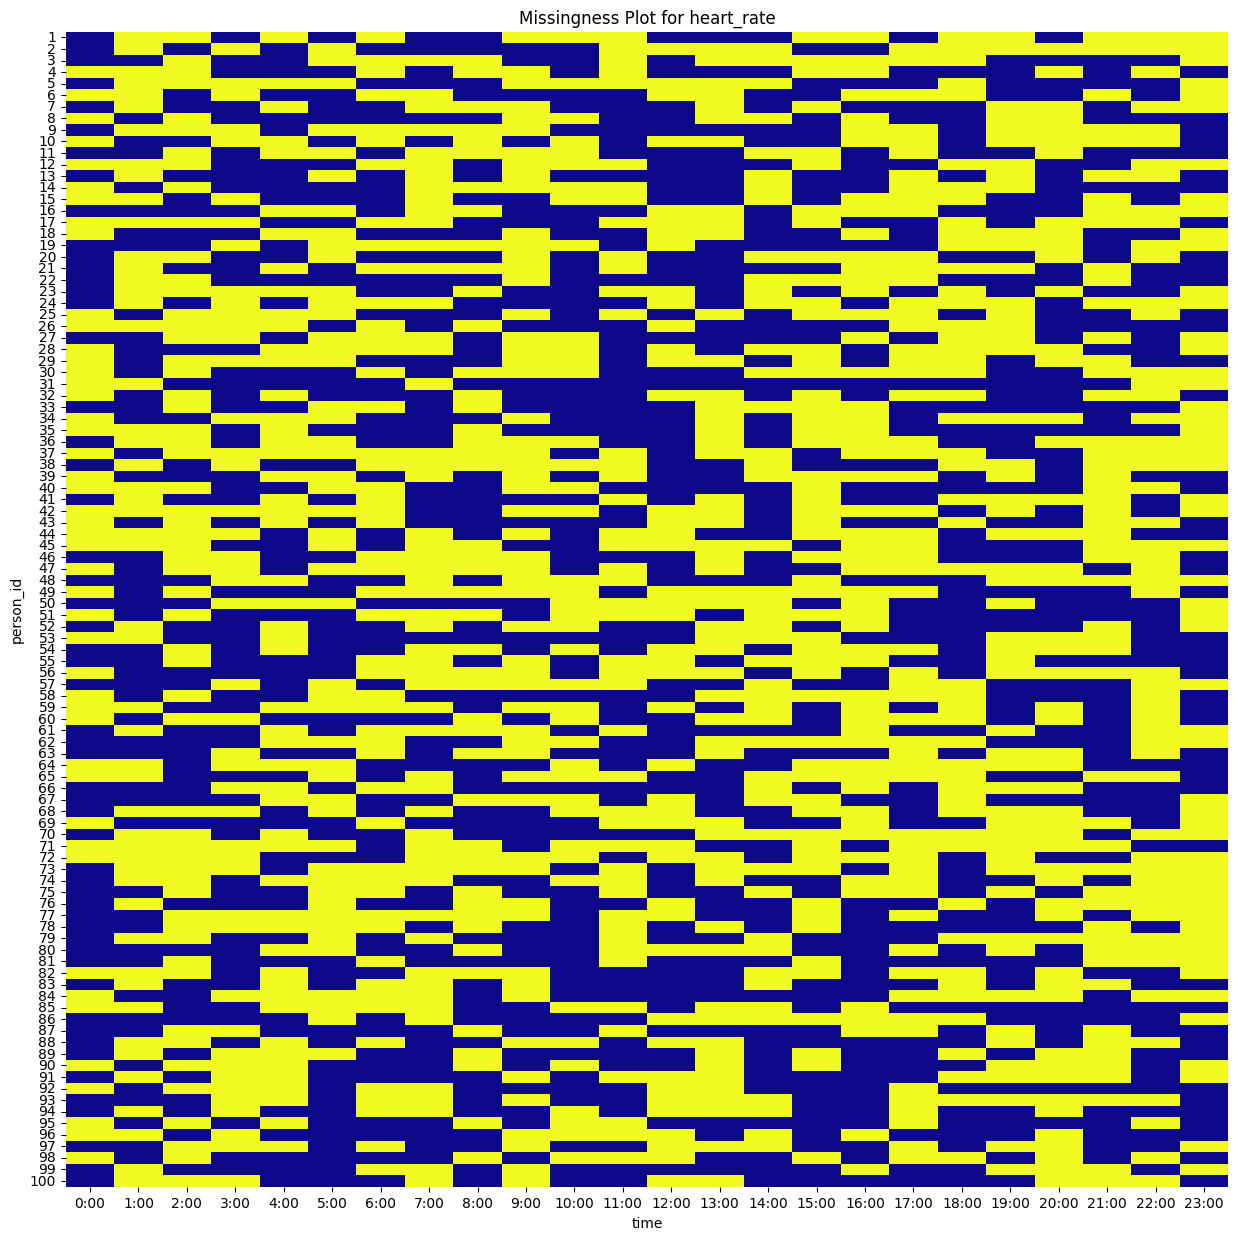

In [80]:
# plot heart_rate and sort by person_id
plot_data = MissingPatternPlot.initialize(df, 'heart_rate', 'study_period')
plot_data.plot('person_id', direction=True, x_ticks='auto', y_ticks=True)

/var/folders/5y/klq_vsbn365gv4d3wvljm_lr0000gn/T/ipykernel_14926/90482788.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['true_prop'] = true_prop


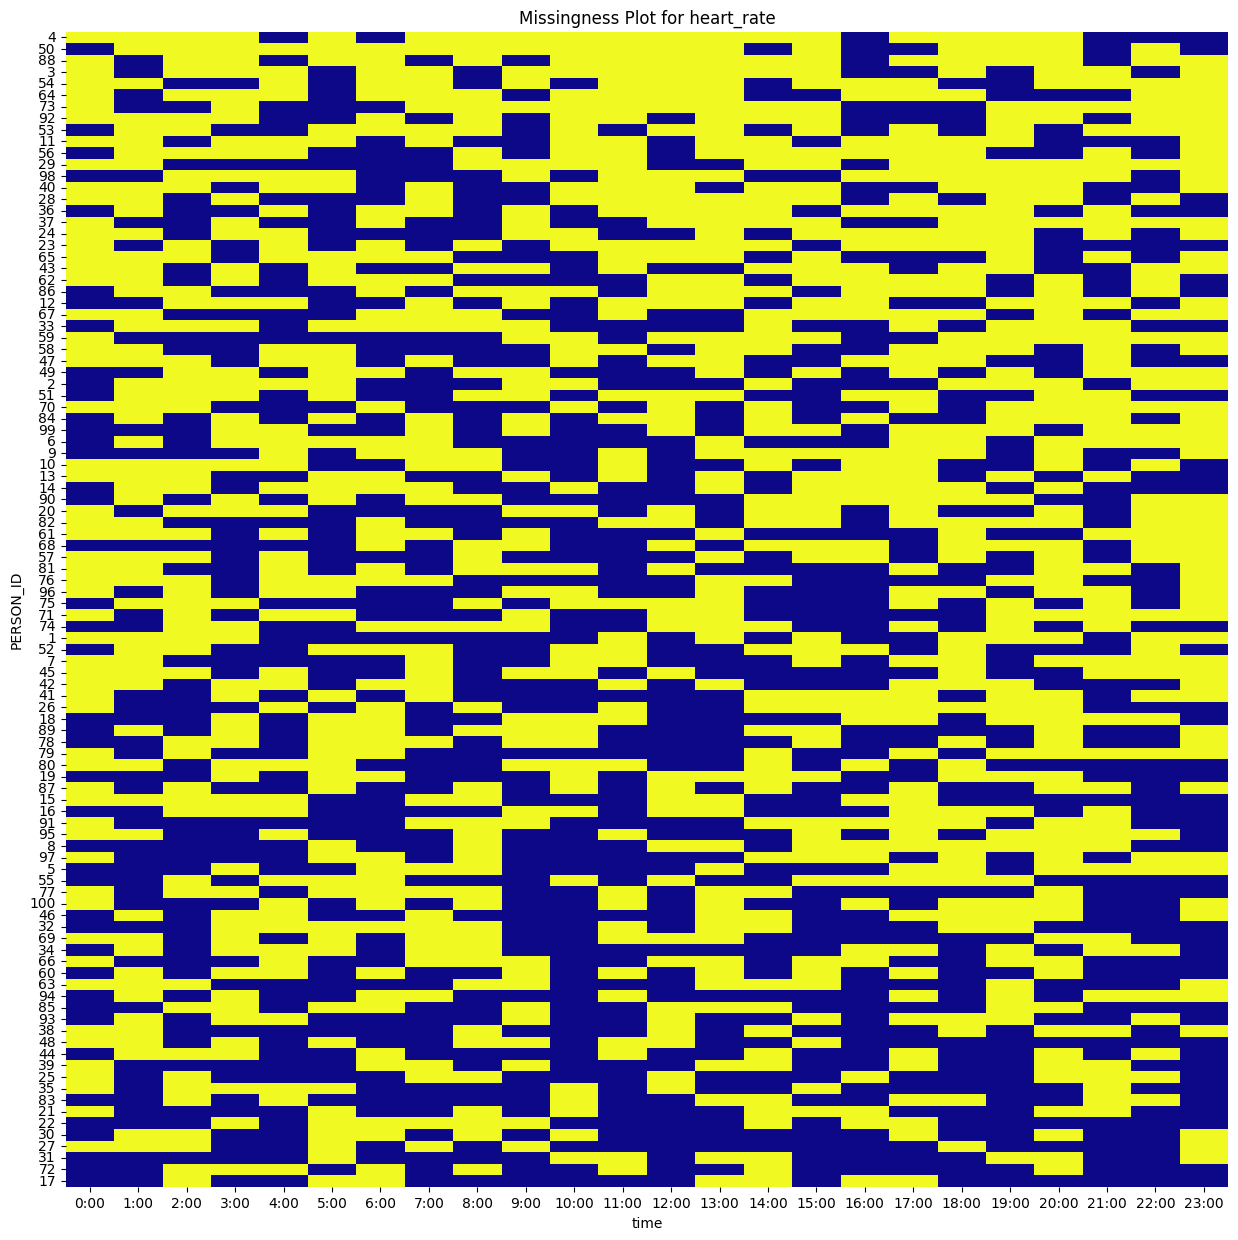

In [62]:
# plot heart_rate and sort by missingness
plot_data.plot('missingness', direction=False, y_label='PERSON_ID', y_ticks=True) # yellow is present, purple is missing

In [64]:
# create a multi-index dataframe header where x_label is distance
header = pd.MultiIndex.from_product([['heart_rate', 'steps'],
                                     ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00',
                                      '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
                                      '21:00', '22:00', '23:00']],
                                      names=['type', 'distance'])

# Generate dummy data
num_rows = 100
num_columns = 48
data = np.random.choice([True, False], size=(num_rows, num_columns))

# Create DataFrame
person_ids = range(1, num_rows + 1)
df = pd.DataFrame(data, index=person_ids, columns=header)

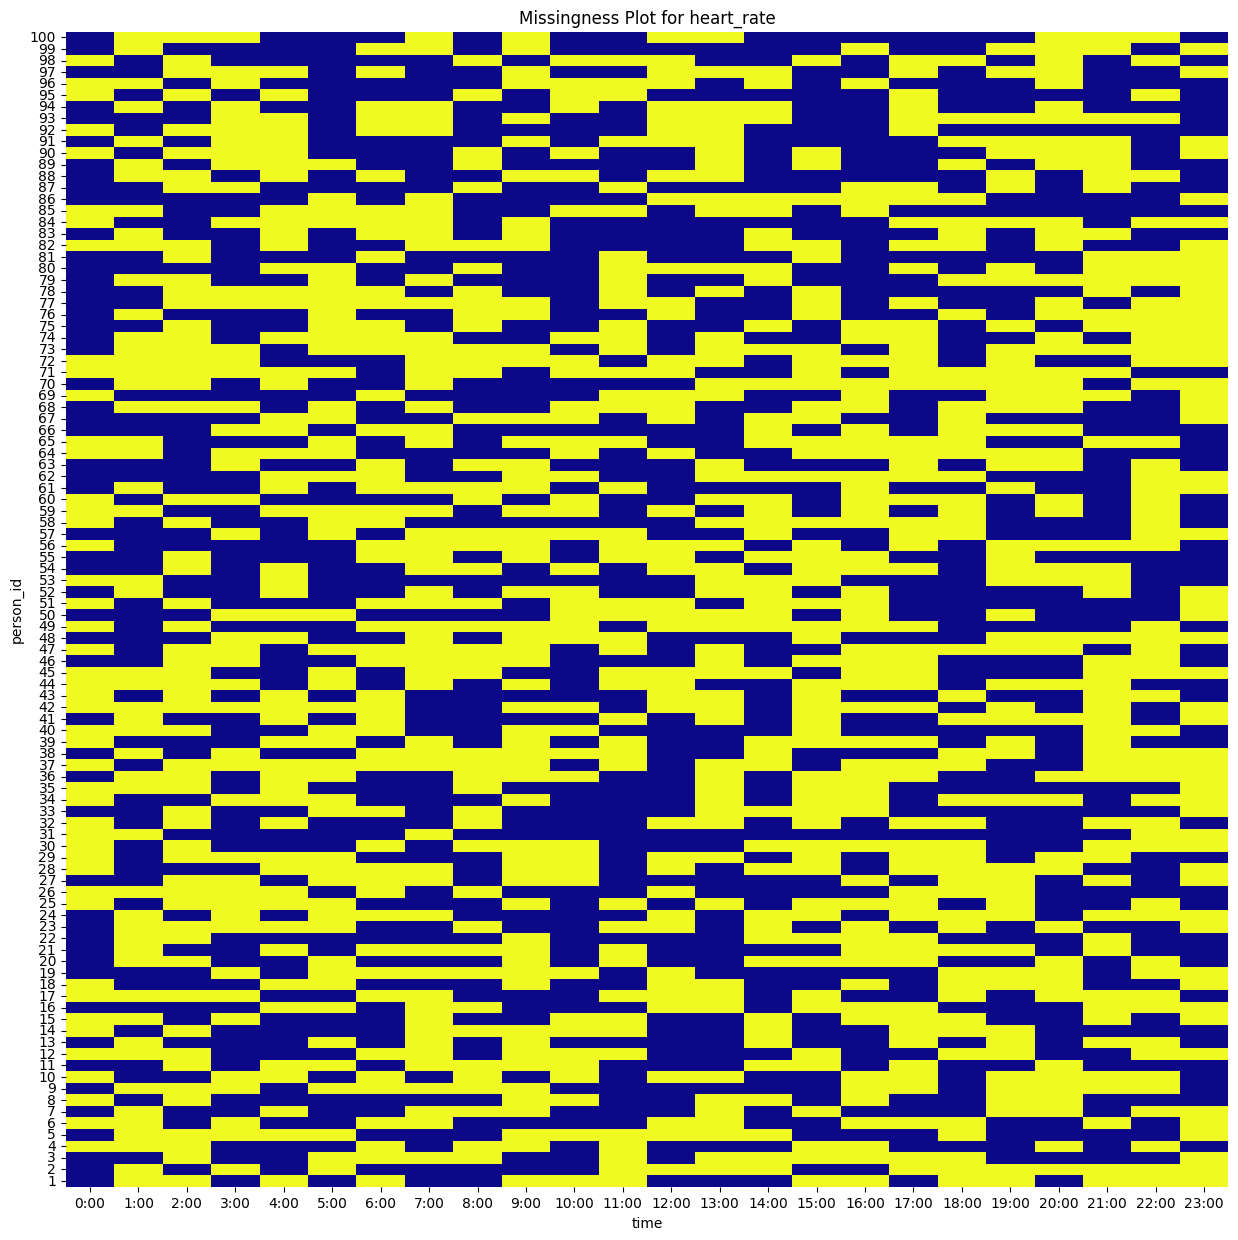

In [83]:
# For non-time x axis
# plot heart_rate and sort by person_id
plot_data = MissingPatternPlot.initialize(df, 'heart_rate', 'study_period')
plot_data.plot('person_id', direction=False, y_ticks=True) # default x_label is from the dataset

In [112]:
# Define the size of the DataFrame
rows = 5
columns = 3

# Create a DataFrame with random True/False values
empty_df = pd.DataFrame(np.random.rand(rows, columns))

# Remove column and row labels
empty_df.columns = [''] * columns  # Make column labels empty
empty_df.index = [''] * rows  # Make row labels empty



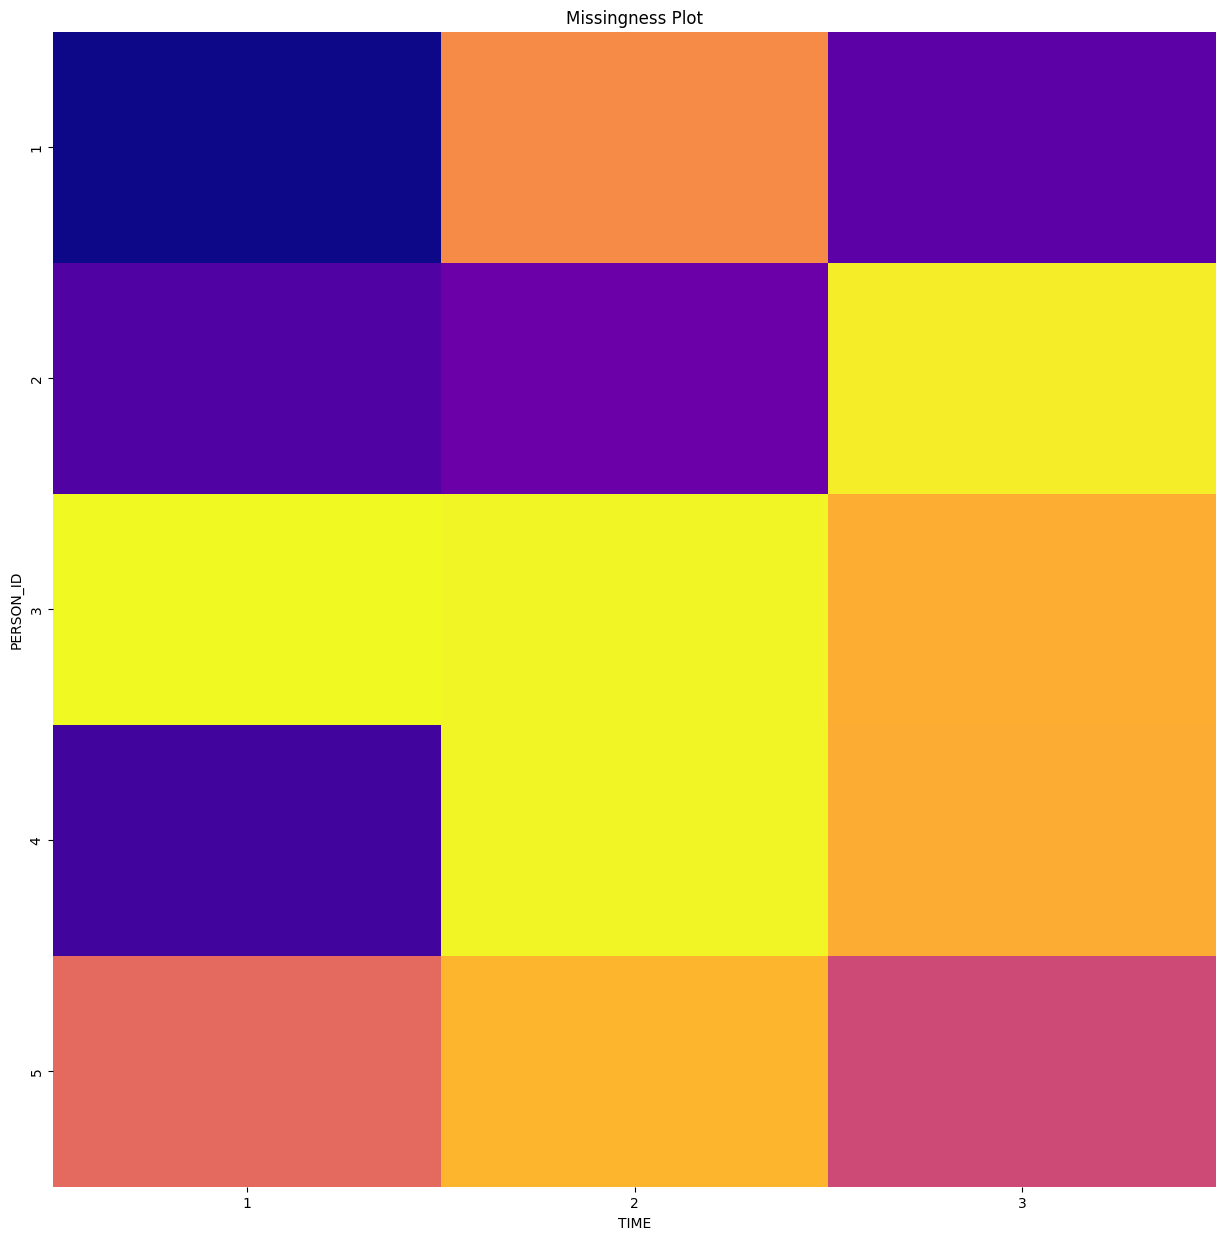

In [113]:
plot_data = MissingPatternPlot.initialize(empty_df, None, 'study_period')
plot_data.plot(direction=True, x_label='TIME', y_label='PERSON_ID', x_ticks=[1,2,3], y_ticks=[1,2,3,4,5])

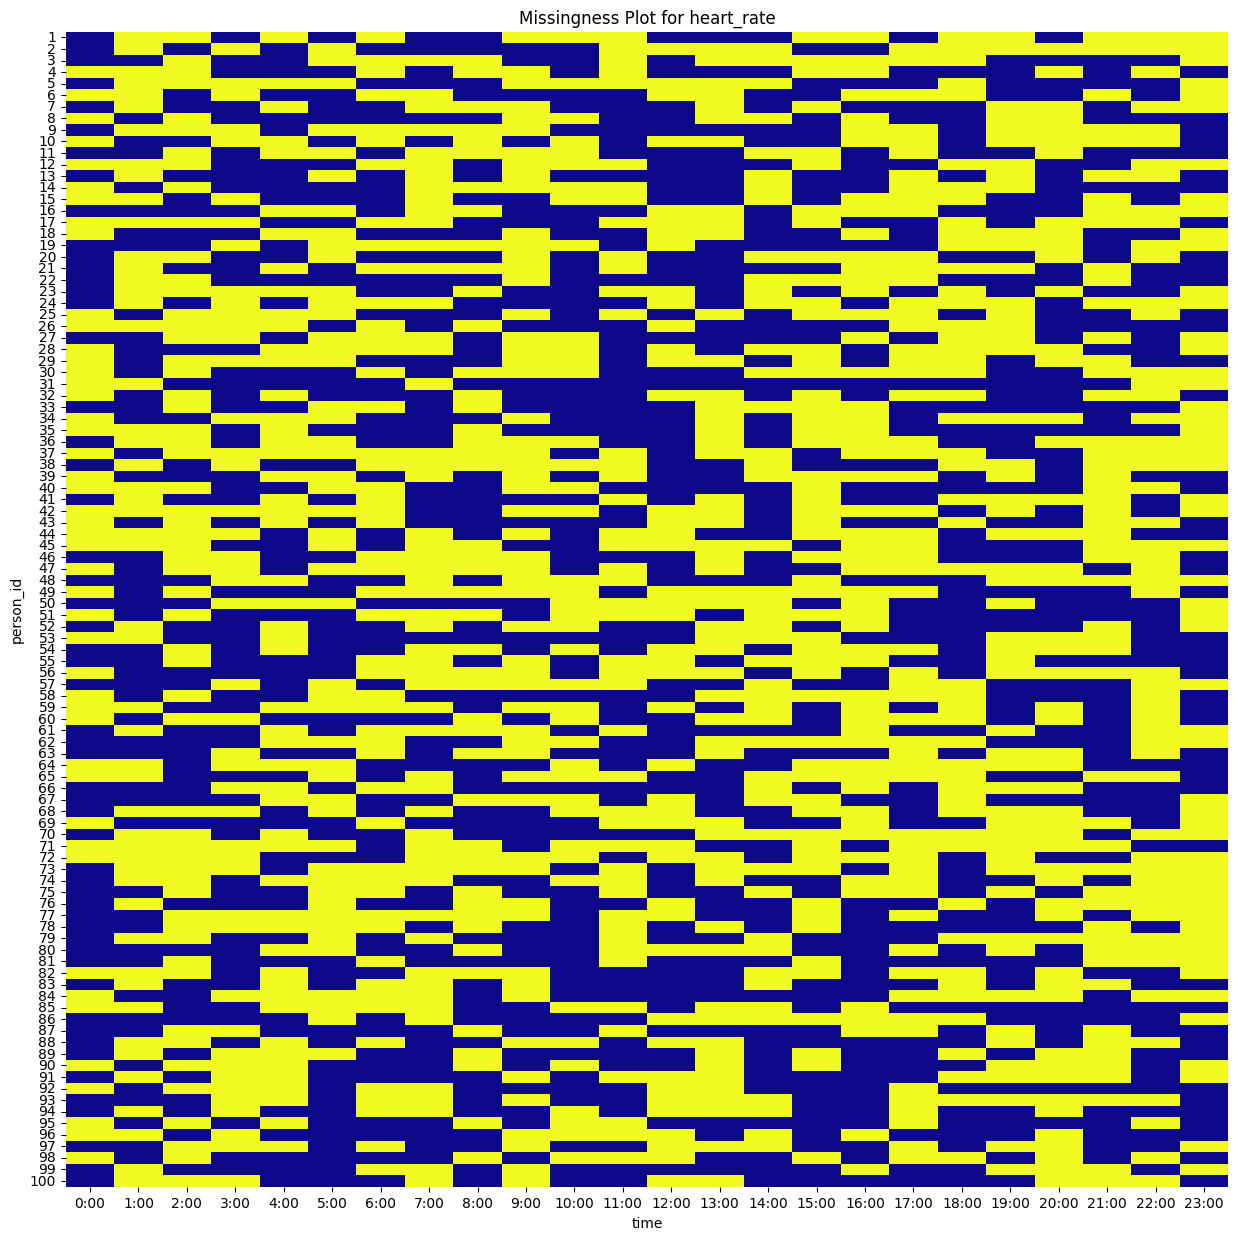

In [107]:
plot_data = MissingPatternPlot.initialize(heart_rates, None, 'study_period')
plot_data.plot('person_id', direction=True, x_ticks='auto', y_ticks=True, title="heart_rate")